## Комментарии по результату

Использовалась модель DeepLab V3+, непредобученная, но с backbone из Resnet 50. Если все верно понял, то backbone использовать можно, что также сказано и в baseline в конкурсе. Использование backbone оправдано, так как данных мало. В аугментациях использовал отражения, повороты и кропы (из исходного изображения сразу кропы нужного размера). Также добавлял дилатацию и эрозию (но не особо принципиально в данном случае).

Модель дает скор 0.85825

Предсказания в submission.csv

## Подготовка и анализ датасета

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import albumentations as album
import segmentation_models_pytorch as smp

In [2]:
DATA_DIR = './flowers_data/'

x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/images')

In [3]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(os.listdir(x_train_dir)))

train_indices, valid_indices = train_test_split(
    indices, test_size=0.1, random_state=30, shuffle=True
)


In [4]:
select_classes = ['background', 'bloom']
select_class_rgb_values = np.array([[  0,   0,   0], [255, 255, 255]])

In [5]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [6]:
class SegmentationDataset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
            split_indexes = None,
    ):
        
        image_names = np.array(sorted(os.listdir(images_dir)))
        masks_names = np.array(sorted(os.listdir(masks_dir)))
        if split_indexes is not None:
            image_names = image_names[split_indexes]
            masks_names = masks_names[split_indexes]
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in image_names]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in masks_names]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

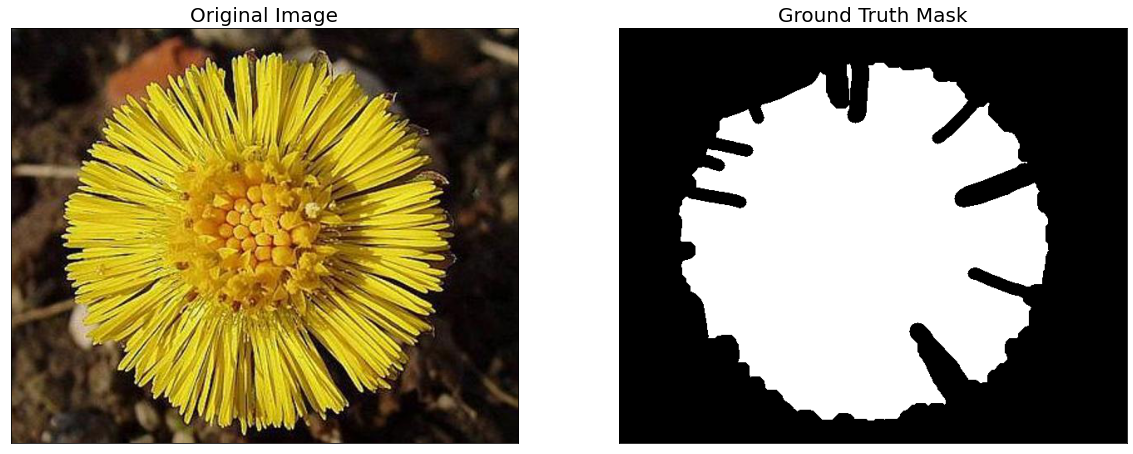

In [7]:
dataset = SegmentationDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    #one_hot_encoded_mask = reverse_one_hot(mask)
)

In [8]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        #album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
        album.Resize(256, 256)
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

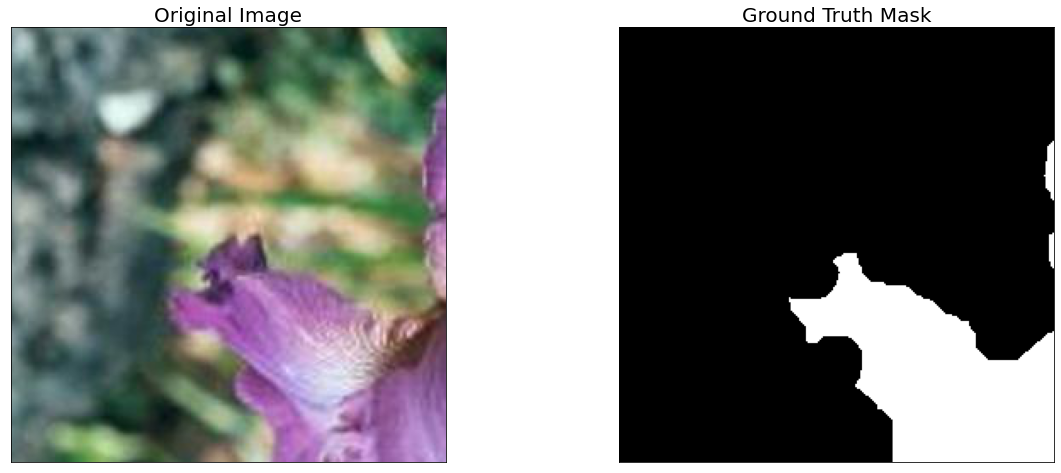

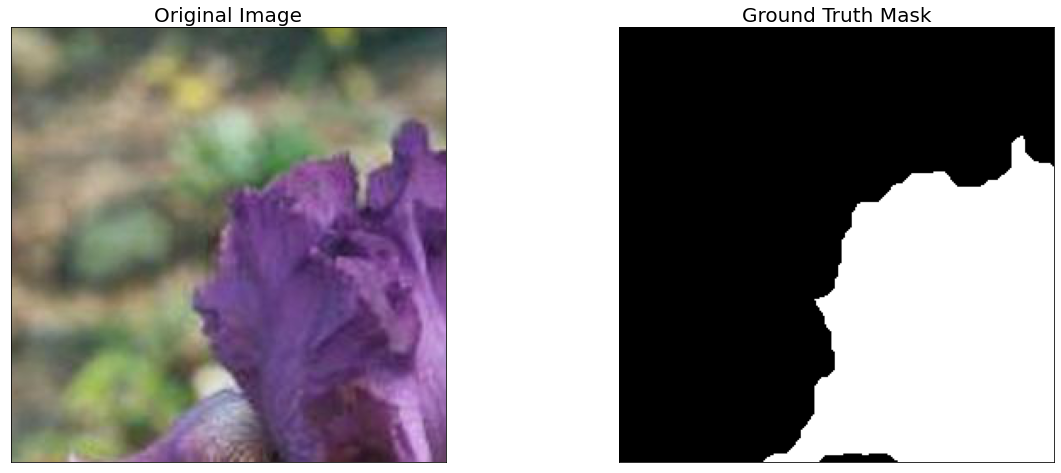

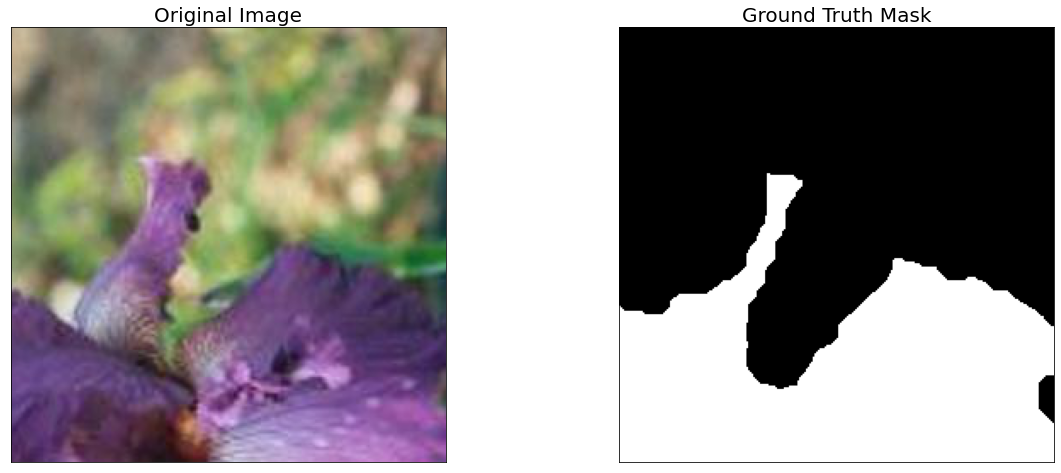

In [9]:
augmented_dataset = SegmentationDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        #one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Модель и обучение

In [10]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid'

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,  
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = None

In [11]:
# Get train and val dataset instances
train_dataset = SegmentationDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
    split_indexes = train_indices,
)

valid_dataset = SegmentationDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
    split_indexes = valid_indices,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [12]:
valid_dataset_vis = SegmentationDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_validation_augmentation(), 
    class_rgb_values=select_class_rgb_values,
    split_indexes = valid_indices,
)

In [13]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 40

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('./best_model.pth'):
    print('Start from checkpoint!')
    model = torch.load('./best_model.pth', map_location=DEVICE)

In [14]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [15]:
len(train_dataset)

368

In [16]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(1, EPOCHS+1):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        #if best_iou_score < valid_logs['iou_score']:
            #best_iou_score = valid_logs['iou_score']
        if i%10==0:
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 1
valid: 100%|███████████████████████████████████| 41/41 [00:01<00:00, 22.40it/s, dice_loss - 0.4426, iou_score - 0.7806]

Epoch: 2
valid: 100%|███████████████████████████████████| 41/41 [00:01<00:00, 23.64it/s, dice_loss - 0.1871, iou_score - 0.8499]

Epoch: 3
valid: 100%|███████████████████████████████████| 41/41 [00:01<00:00, 23.03it/s, dice_loss - 0.1348, iou_score - 0.8554]

Epoch: 4
valid: 100%|███████████████████████████████████| 41/41 [00:01<00:00, 24.27it/s, dice_loss - 0.1262, iou_score - 0.8629]

Epoch: 5
valid: 100%|███████████████████████████████████| 41/41 [00:01<00:00, 22.10it/s, dice_loss - 0.1018, iou_score - 0.8857]

Epoch: 6
valid: 100%|██████████████████████████████████| 41/41 [00:01<00:00, 21.49it/s, dice_loss - 0.09545, iou_score - 0.8966]

Epoch: 7
valid: 100%|██████████████████████████████████| 41/41 [00:01<00:00, 23.51it/s, dice_loss - 0.09054, iou_score - 0.8956]

Epoch: 8
valid: 100%|███████████████████████████████████| 41/41 [00:01<00:00, 23.75it/s, 

valid: 100%|██████████████████████████████████| 41/41 [00:01<00:00, 20.71it/s, dice_loss - 0.06158, iou_score - 0.8924]

Epoch: 34
valid: 100%|██████████████████████████████████| 41/41 [00:01<00:00, 21.48it/s, dice_loss - 0.05075, iou_score - 0.9149]

Epoch: 35
valid: 100%|██████████████████████████████████| 41/41 [00:01<00:00, 22.88it/s, dice_loss - 0.05416, iou_score - 0.9091]

Epoch: 36
valid: 100%|██████████████████████████████████| 41/41 [00:01<00:00, 22.69it/s, dice_loss - 0.05336, iou_score - 0.9078]

Epoch: 37
valid: 100%|███████████████████████████████████| 41/41 [00:02<00:00, 17.30it/s, dice_loss - 0.05877, iou_score - 0.898]

Epoch: 38
valid: 100%|██████████████████████████████████| 41/41 [00:01<00:00, 22.77it/s, dice_loss - 0.05257, iou_score - 0.9079]

Epoch: 39
valid: 100%|██████████████████████████████████| 41/41 [00:01<00:00, 22.46it/s, dice_loss - 0.05468, iou_score - 0.9037]

Epoch: 40
valid: 100%|███████████████████████████████████| 41/41 [00:01<00:00, 22.47it/s, dic

In [17]:
kernel = np.ones((3,3),np.uint8)

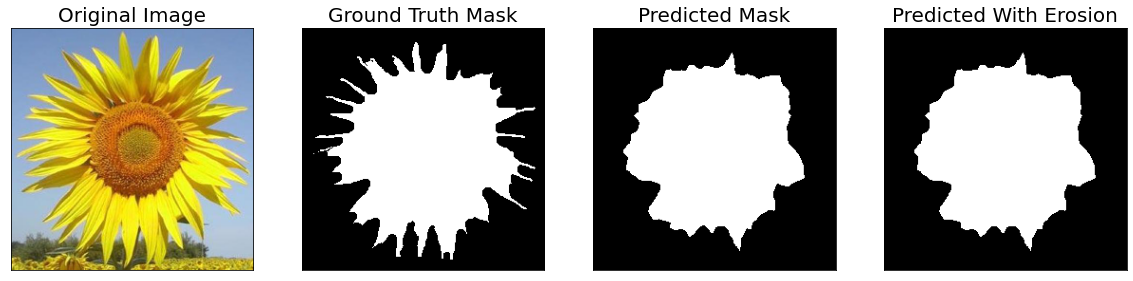

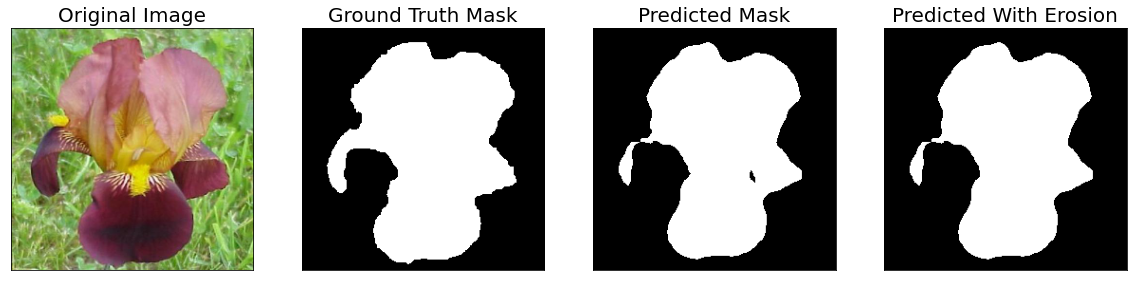

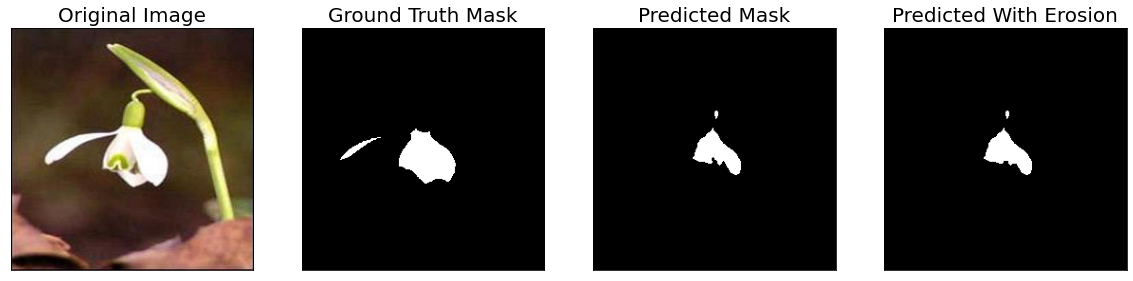

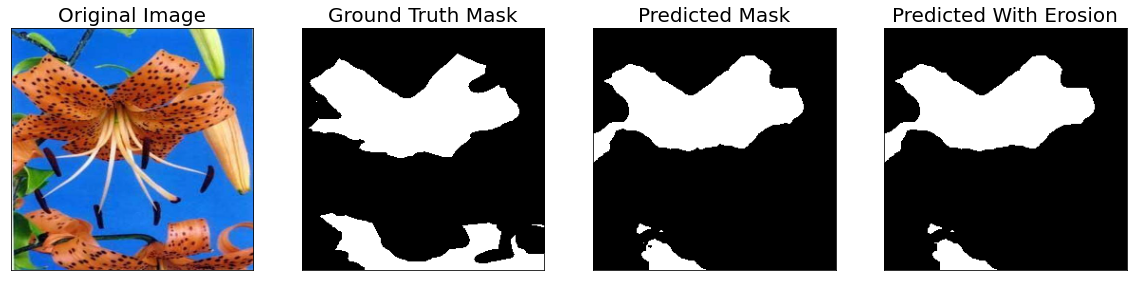

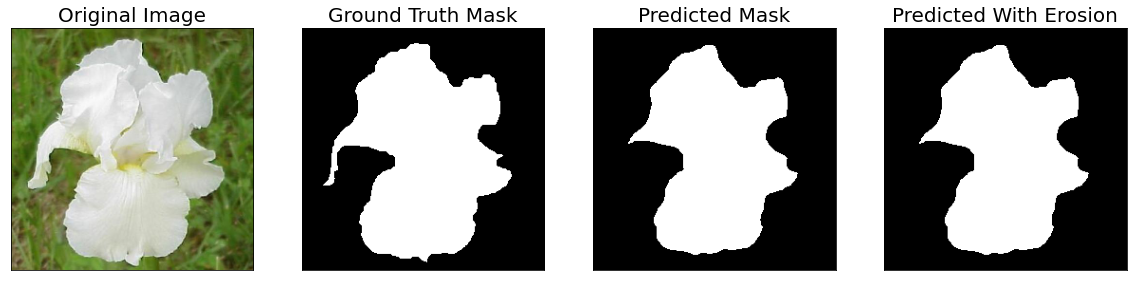

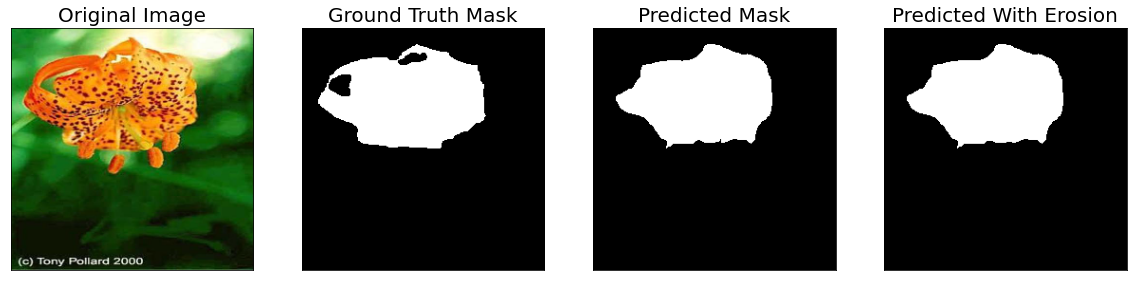

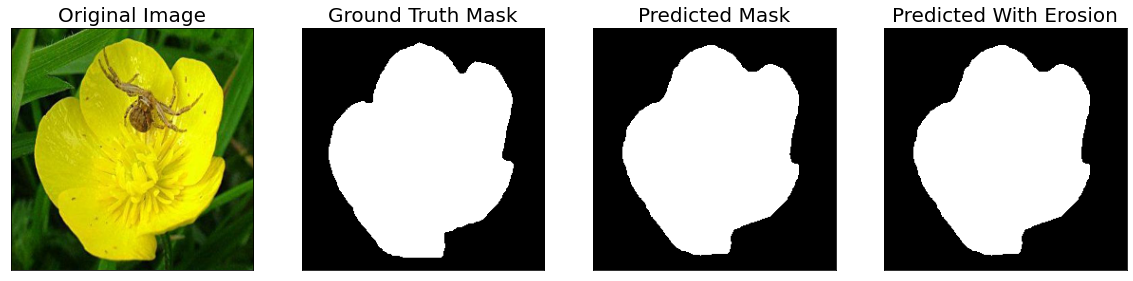

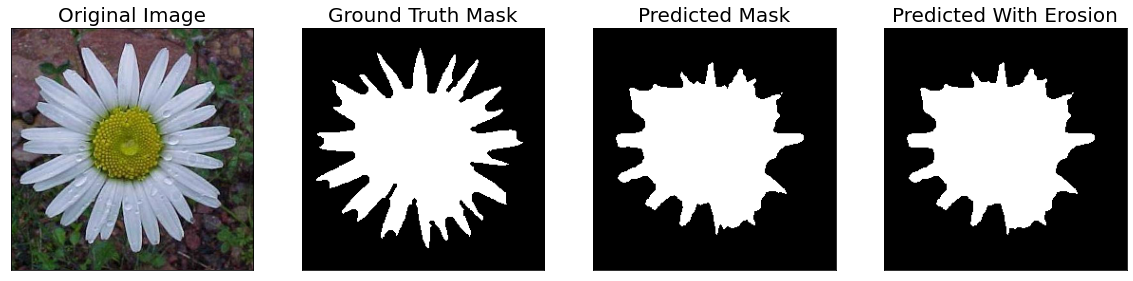

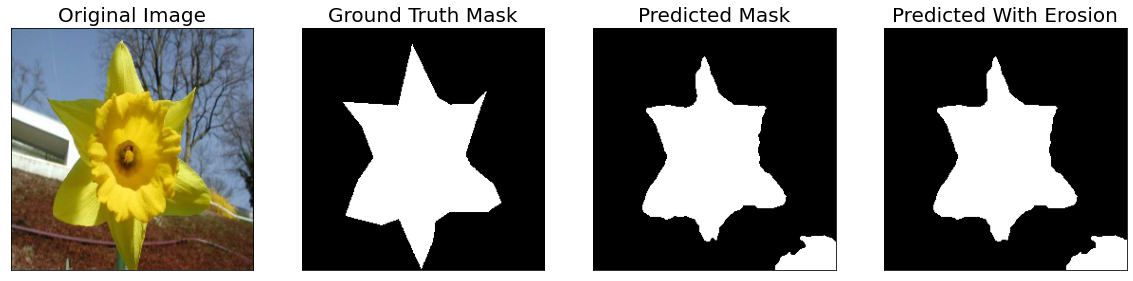

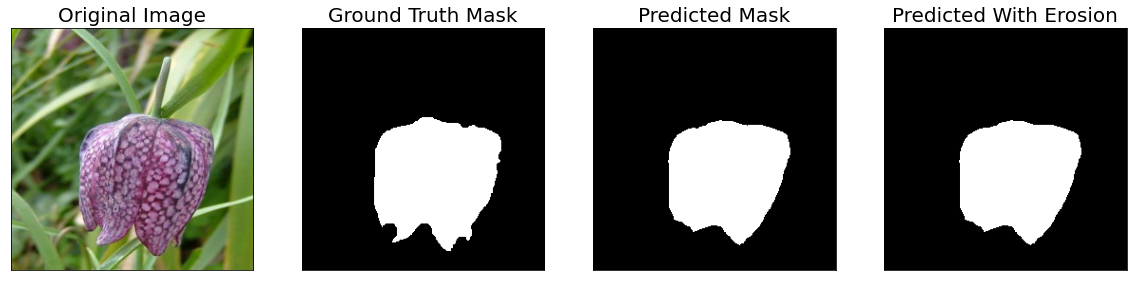

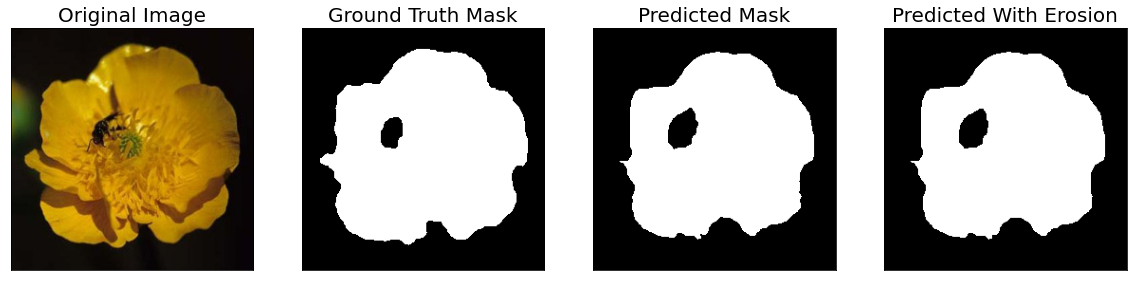

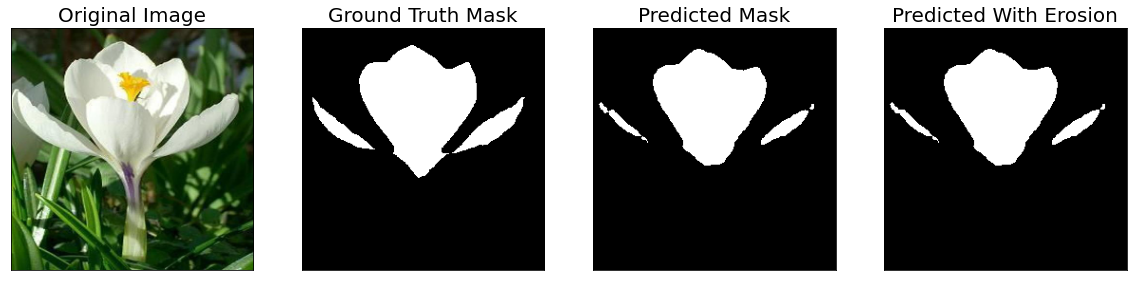

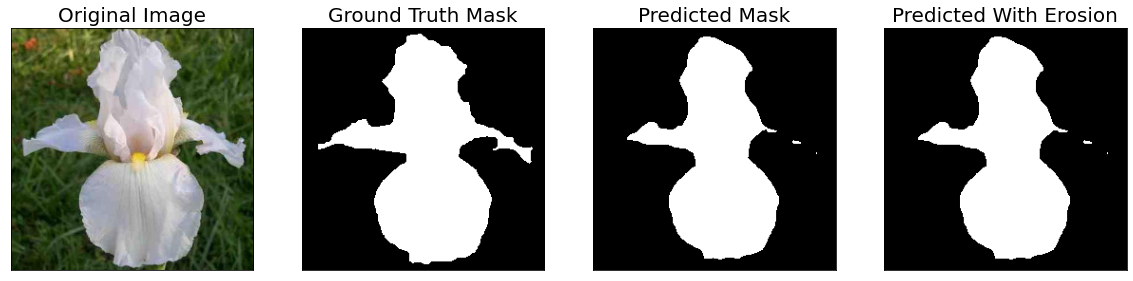

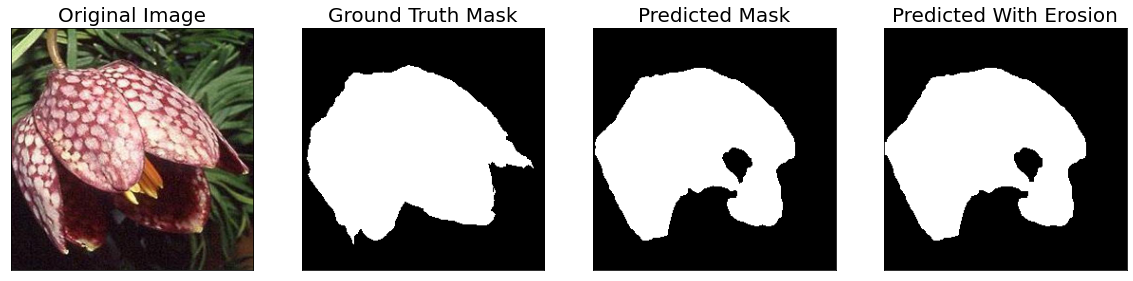

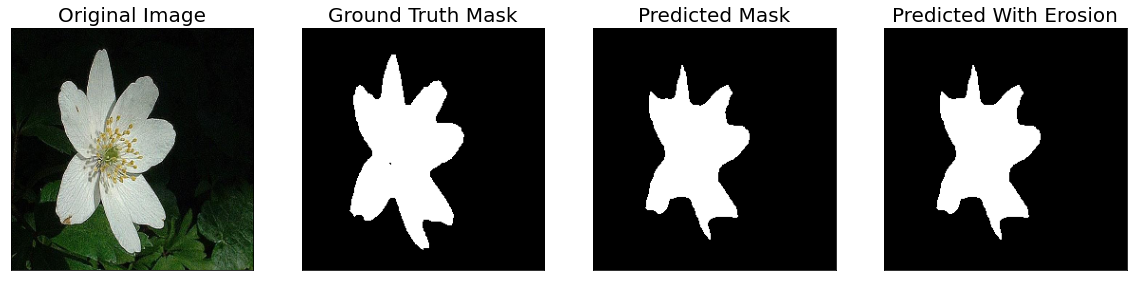

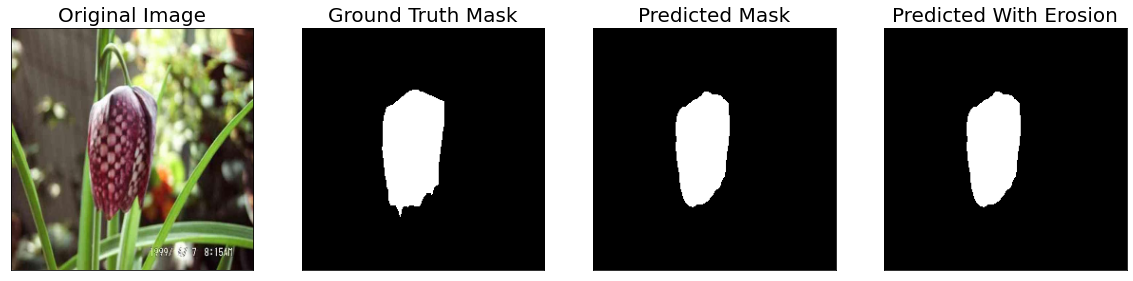

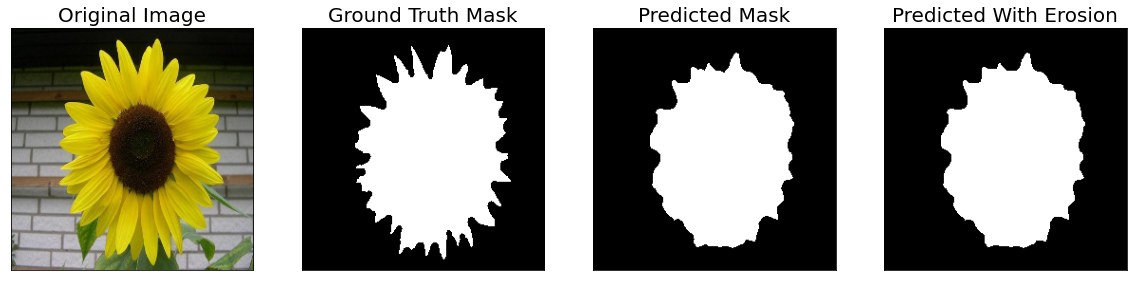

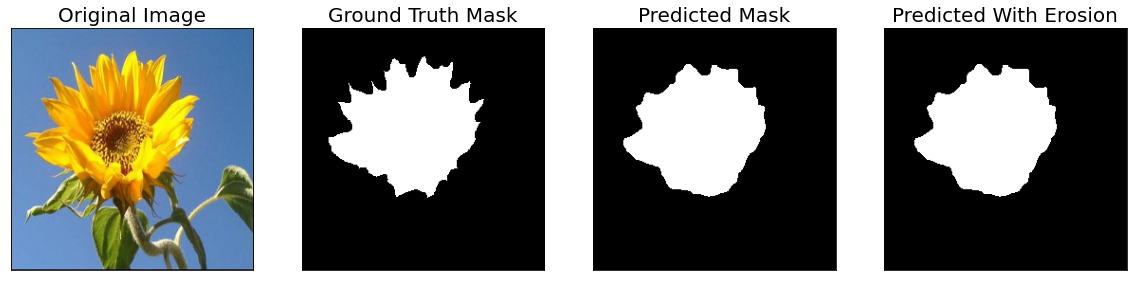

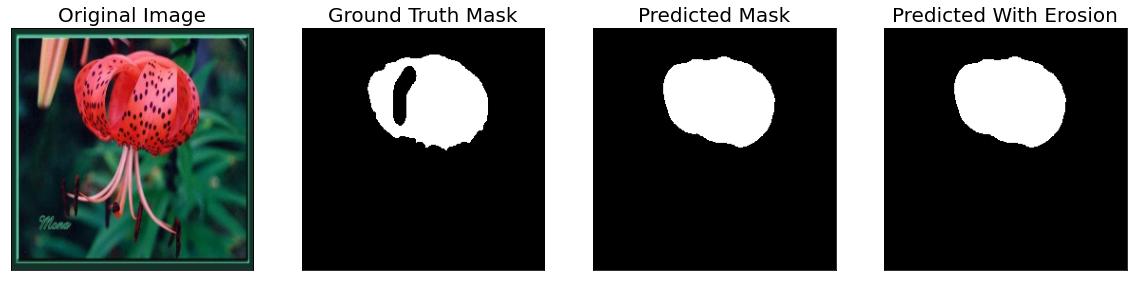

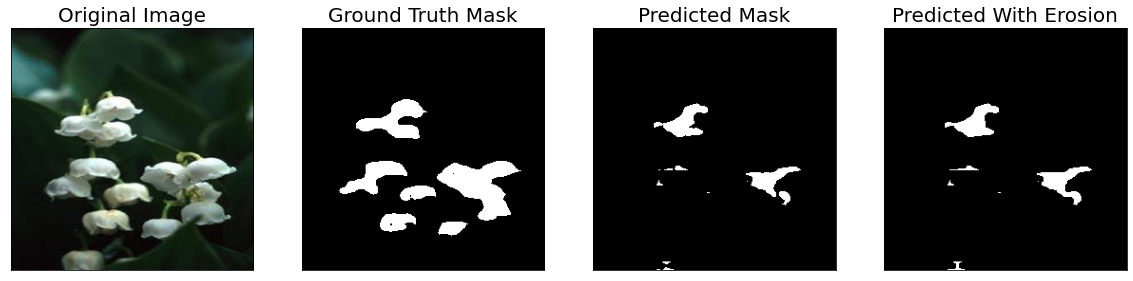

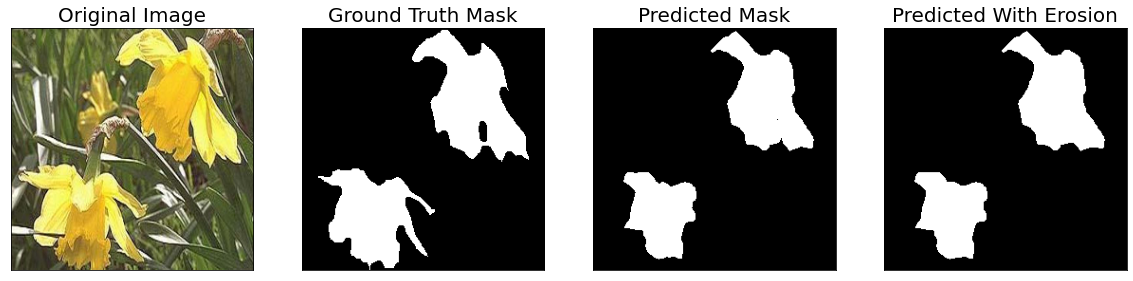

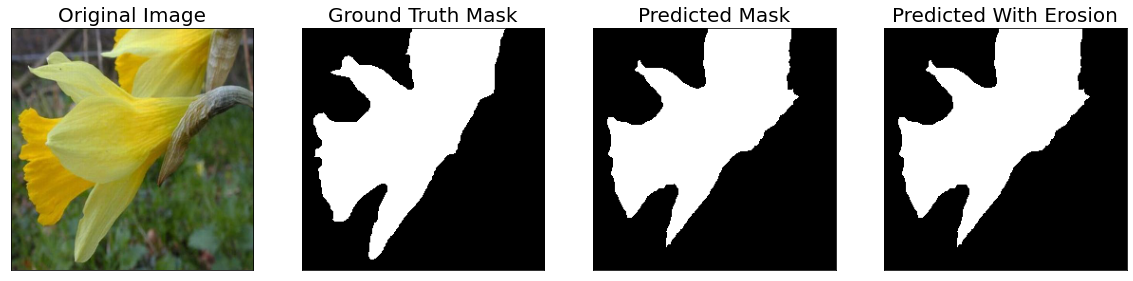

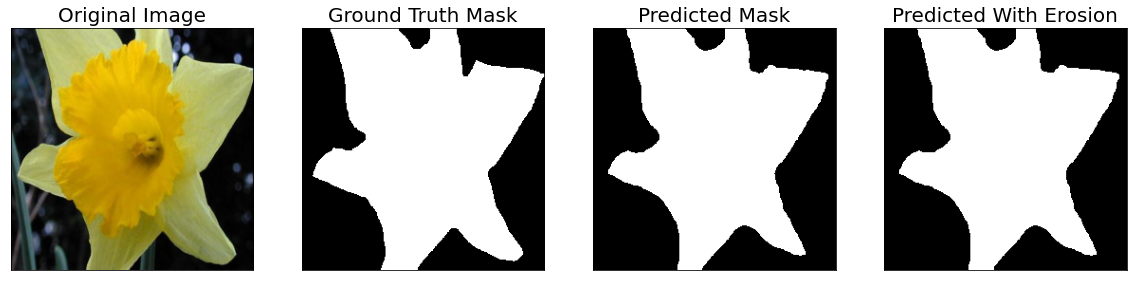

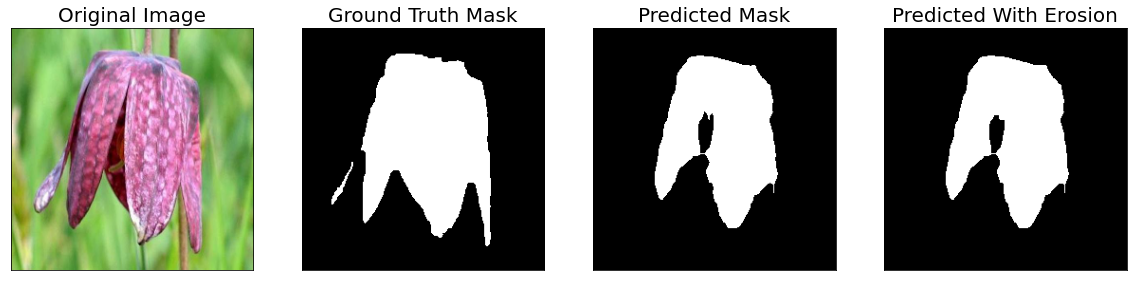

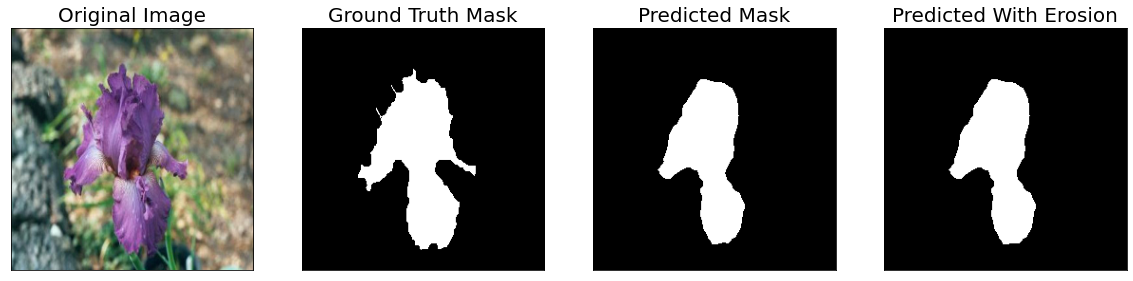

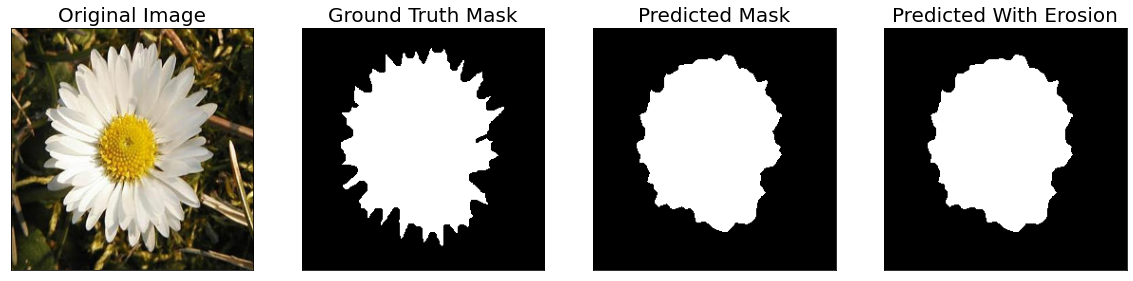

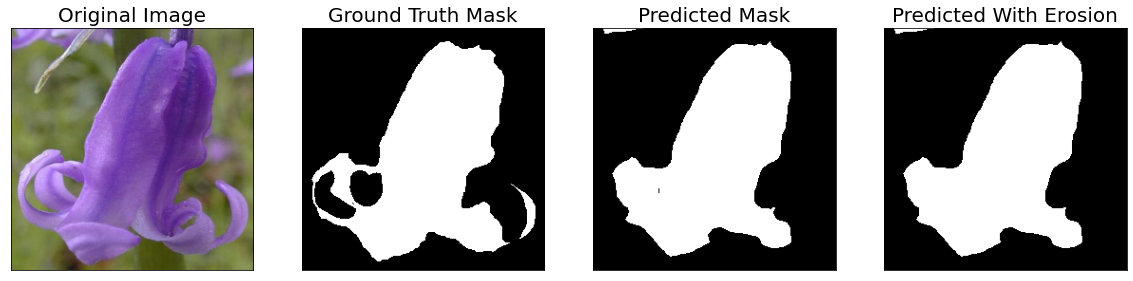

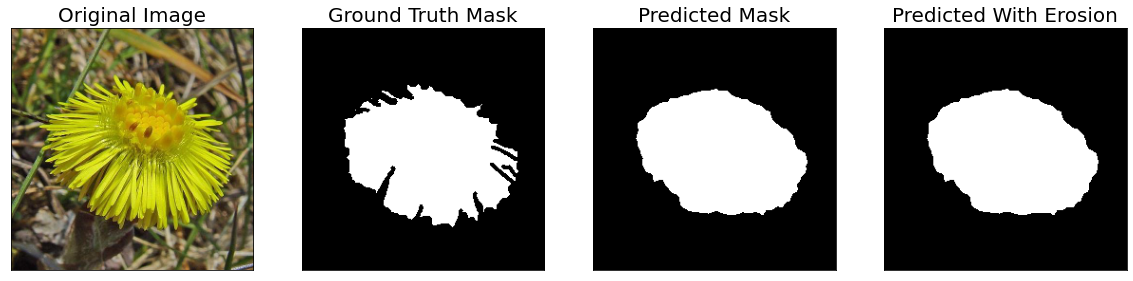

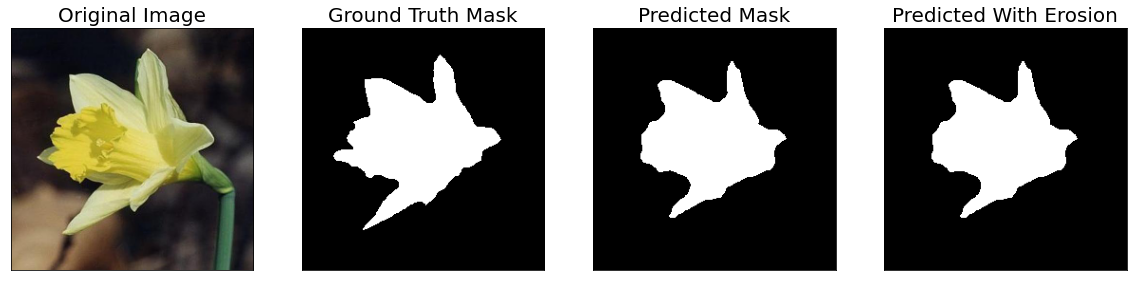

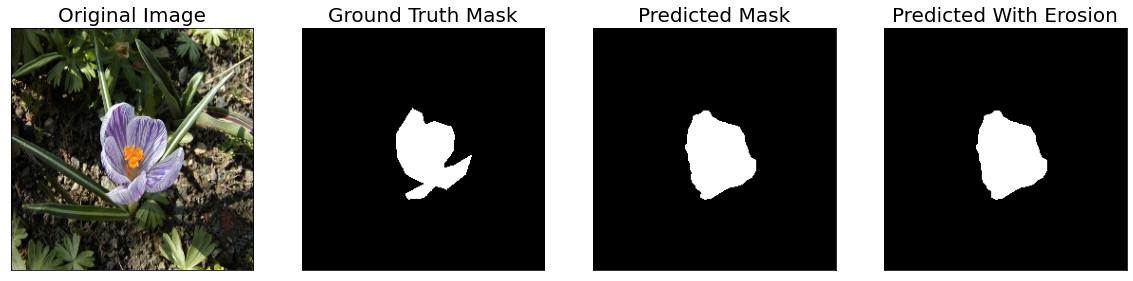

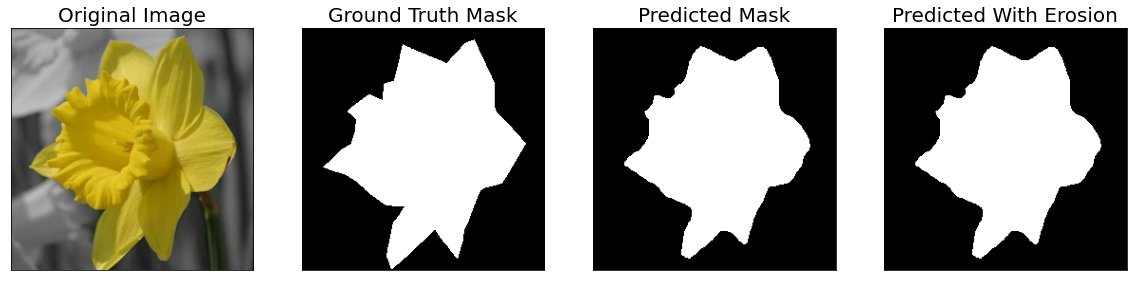

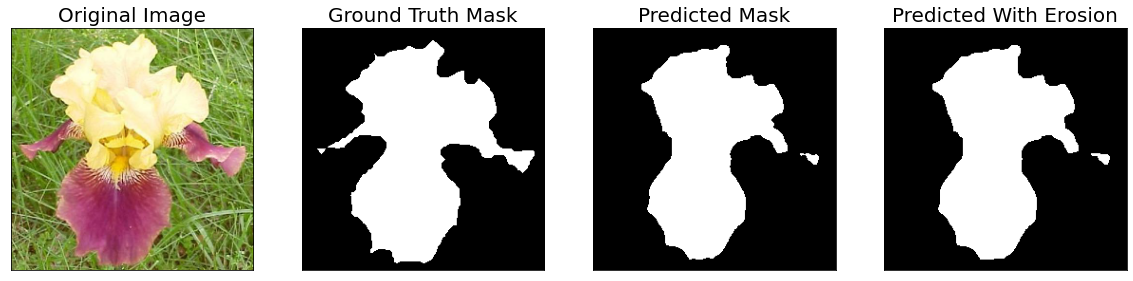

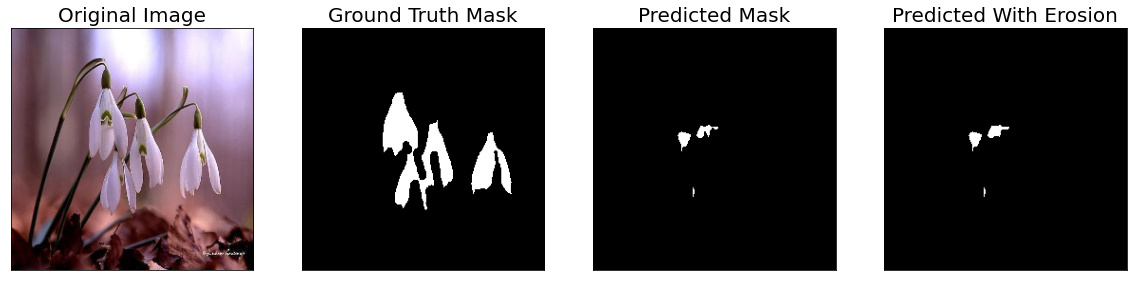

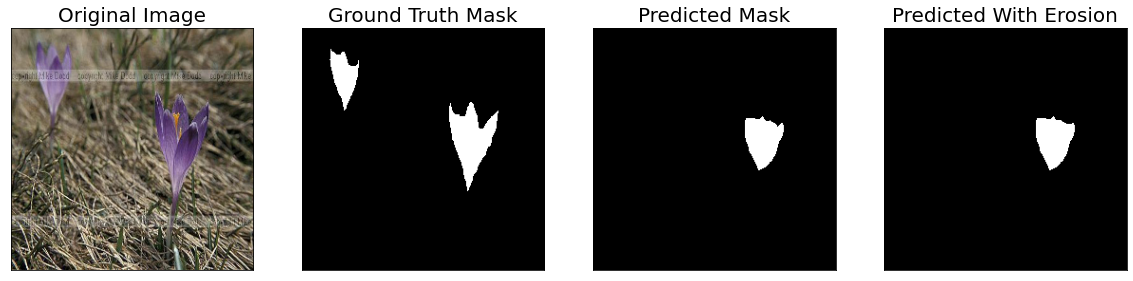

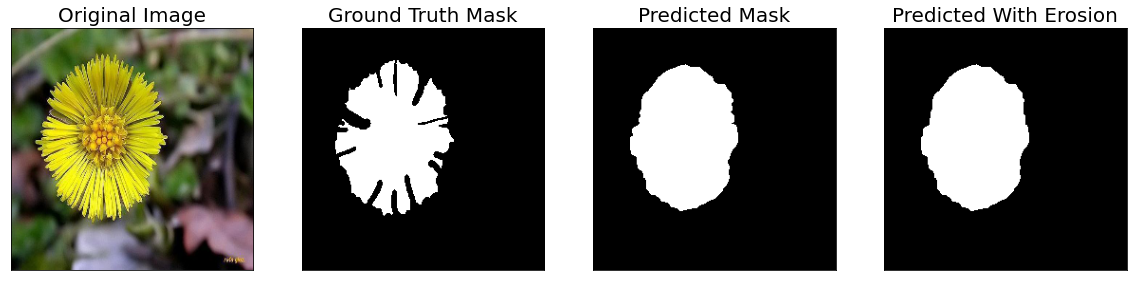

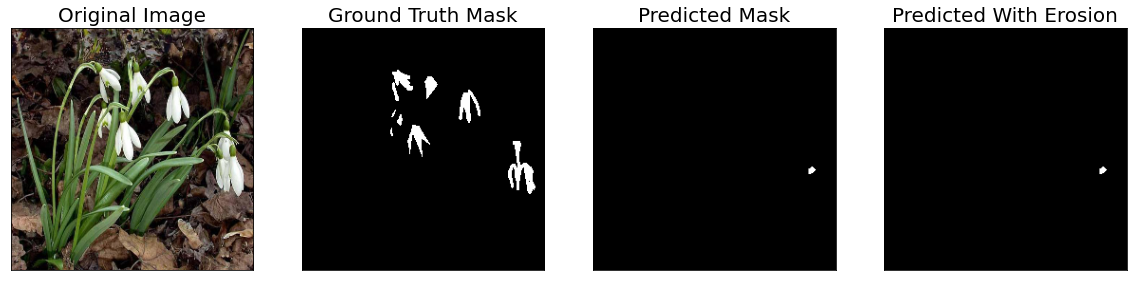

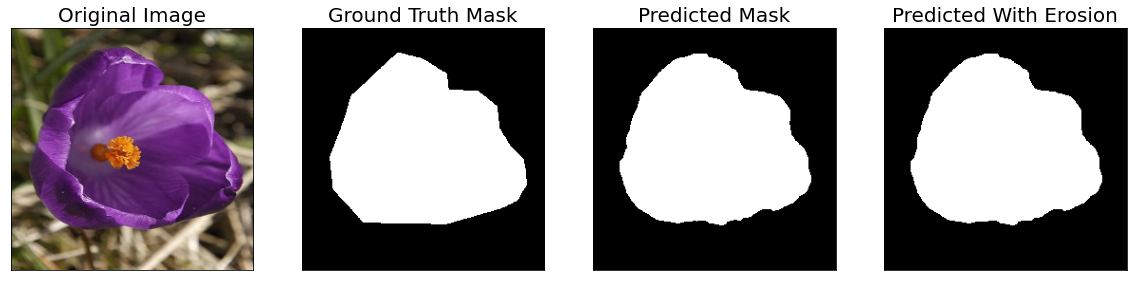

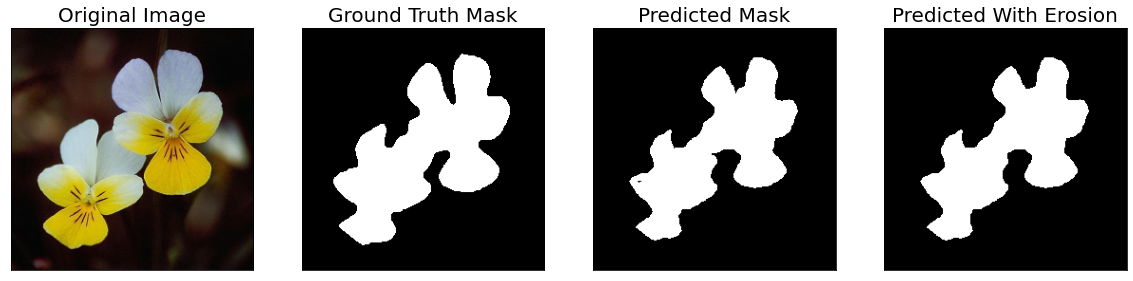

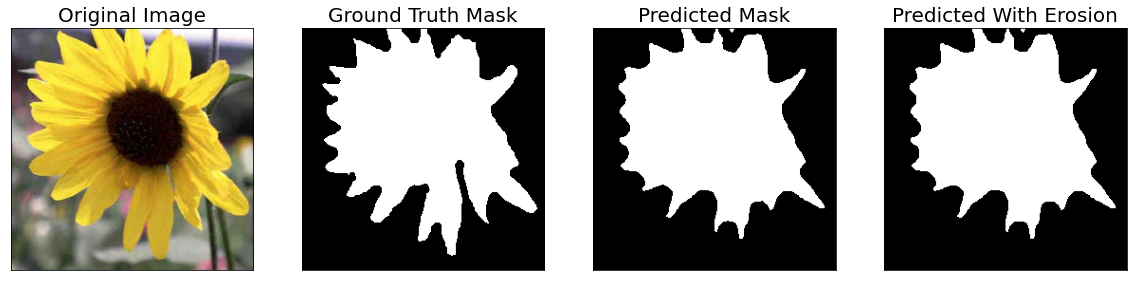

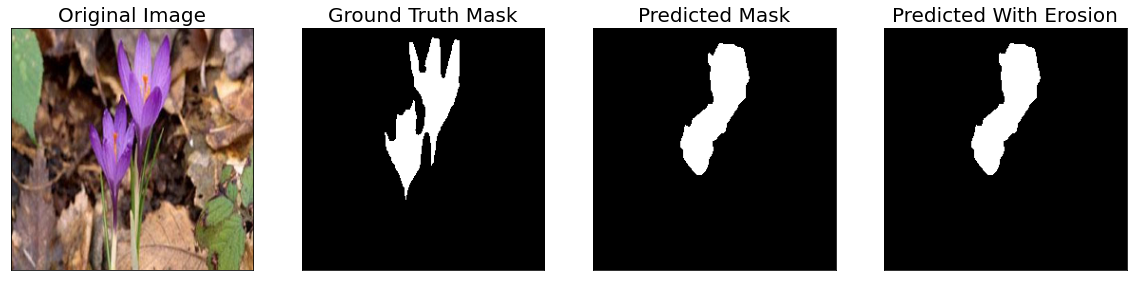

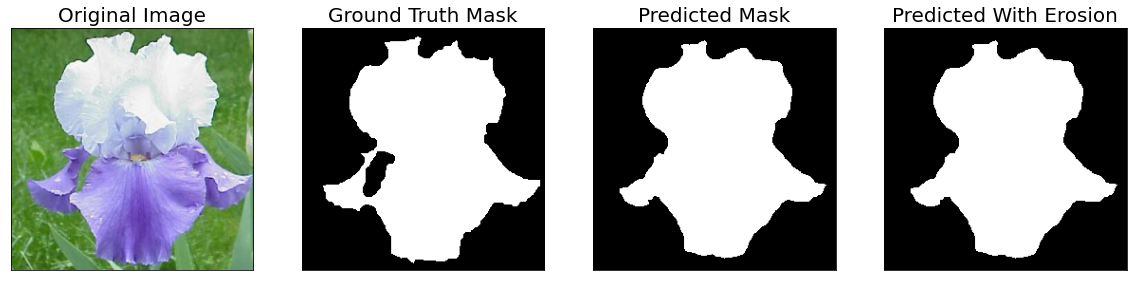

In [18]:
for idx in range(len(valid_dataset)):

    image, gt_mask = valid_dataset[idx]
    image_vis = valid_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    #print(x_tensor.shape)
    # Predict test image
    pred_mask = model(x_tensor)#[:,:,:,:1000])
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to road
    pred_road_heatmap = pred_mask[:,:,select_classes.index('bloom')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    erosion_mask = cv2.dilate(np.array(pred_mask[:,:,::-1], dtype='uint8'),kernel,iterations = 2)
    erosion_mask = cv2.erode(erosion_mask,kernel,iterations = 2)
    #cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_with_erosion = erosion_mask
    )

## Сохранение масок для теста. Submission

In [19]:
def get_test_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

test_dataset = SegmentationDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_test_augmentation(),
    #augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataset_vis = SegmentationDataset(
    x_test_dir, y_test_dir, 
    #augmentation=get_test_augmentation(), 
    class_rgb_values=select_class_rgb_values,
)

In [20]:
def crop_image(image, target_image_dims):
   
    target_size_h = target_image_dims[0]
    target_size_w = target_image_dims[1]
    image_size_h = image.shape[0]
    image_size_w = image.shape[1]
    padding_h = (image_size_h - target_size_h) // 2
    padding_w = (image_size_w - target_size_w) // 2
    s_h = (image_size_h - target_size_h) % 2
    s_w = (image_size_w - target_size_w) % 2

#     if padding<0:
#         return image
    return image[
        padding_h:image_size_h - padding_h - s_h,
        padding_w:image_size_w - padding_w - s_w
    ]

In [21]:
def rle_encoding(x):
    """
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    """
    dots = np.where(x.T.flatten() == 1)[
        0
    ]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [ ]:
sample_preds_folder = './flowers_data/test/sample_predictions_deeplabv3plus_pretrained/'
submission = {"ImageId": [], "EncodedPixels": []}

for idx in range(len(test_dataset)):
    image, gt_mask = test_dataset[idx]
    img_name = os.path.splitext(os.path.basename(test_dataset.image_paths[idx]))[0]
    submission["ImageId"].append(img_name)
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = model(x_tensor)#[:,:,:,:1000])
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to road
    pred_road_heatmap = pred_mask[:,:,select_classes.index('bloom')]
    pred_mask = reverse_one_hot(pred_mask)
    pred_mask = crop_image(pred_mask, image_vis.shape)
    rle_encode = rle_encoding(pred_mask)
    submission["EncodedPixels"].append(rle_encode)
    pred_mask = colour_code_segmentation(pred_mask, select_class_rgb_values)
    #pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    #gt_mask = np.transpose(gt_mask,(1,2,0))
    #gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    erosion_mask = cv2.dilate(np.array(pred_mask[:,:,::-1], dtype='uint8'),kernel,iterations = 2)
    erosion_mask = cv2.erode(erosion_mask,kernel,iterations = 2)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, pred_mask, erosion_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        predicted_mask = pred_mask,
        predicted_with_erosion = erosion_mask
    )

In [23]:
pd.DataFrame(submission).to_csv("submission.csv", index=False)